# Проект для «Викишоп»

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Задача:**
 - обучить модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
 - построить модель со значением метрики качества *F1* не меньше 0.75. 

**Порядок выполнения**

1. Подготовка данных.
2. Обучение разных моделей. 
3. Вывод.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`:
 - Столбец *text* - содержит текст комментария, 
 - *toxic* — целевой признак.

## Подготовка

In [1]:
#установим некоторые доп библиотеки
!pip install scikit-learn==1.5.0 -q
!pip install matplotlib==3.5.2 -q
!pip install nltk -q
!pip install spacy -q
!spacy download en_core_web_sm -q
!/opt/conda/bin/python -m pip install wordcloud==1.8.2.2 -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
#импортируем необходимые библиотеки,отключим предупреждения (в конце), 
#зададим формат вывода знаков после запятой

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import re
import sys
import spacy
import nltk
import time
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from tqdm import tqdm
from tqdm.notebook import trange, tqdm
from time import sleep
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import ComplementNB
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from wordcloud import WordCloud
from nltk.probability import FreqDist
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# загружаем функцию для работы с метриками
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression

#отключим предупреждения (в конце)
import warnings
warnings.filterwarnings('ignore')


#зададим формат окна
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.options.display.float_format = '{:,.2f}'.format

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Загрузим данные, выгрузим любые 5 строк и посмотрим инфо

In [3]:
#загрузим данные из файла 
try:
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col = 0)
except:    
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col = 0)
#выведем любые 5 строк
data.sample(5)

,text,toxic
156244,Jimbo could only get this barnstar if he had b...,0
22842,REDIRECT Talk:2005–06 Chappell–Hadlee Trophy,0
67476,Hyperlink edits \n\nTwo incorrect hyperlinks a...,0
149042,"""\nI believe it's rolling out slowly. I had a...",0
91888,I have confirmed this change by contacting Act...,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Данные представлены 2-мя столбцами, кол-во строк - 159292, пропуски отсутствуют.

Проверим на наличие дубликатов полных и в тексте

In [5]:
print('Кол-во полных дубликатов:',data.duplicated().sum(),\
      '\nКол-во дубликатов твитов:',data['text'].duplicated().sum())

Кол-во полных дубликатов: 0 
Кол-во дубликатов твитов: 0


Дубликаты отсутствуют.

Проверим какими значениями представлен целевой признак

In [6]:
data['toxic'].unique()

array([0, 1])

Значения только 0 и 1. 

Оценим распределение данных - построим диаграмму

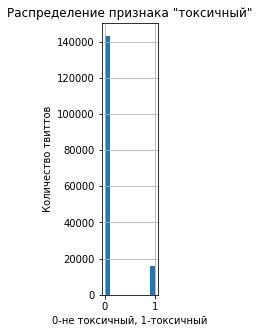

In [7]:
data['toxic'].hist(figsize=(1,5));
plt.title('Распределение признака "токсичный"')
plt.xlabel('0-не токсичный, 1-токсичный');
plt.ylabel('Количество твиттов');

Целевой признак не сбалансирован по классами с перевесом в пользу класса 0 в 7 раз. Учтем этот факт  при делении датафрейма на обучающие и тестовые выборки.



In [8]:
#выделим часть выборки для ускорения обучения
data_sample = data.loc[:75000, :]#зафиксим выборку
#выведем первые 5 строк полученной выборки
data_sample.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Далее очистим текст от лишнего, проведем лемматизацию(исключая стоп-слова)

In [9]:
#создадим функцию для очистки текста
def clear(text):
    text = ' '.join(re.sub(r'[^a-zA-Z ]', ' ', text).split()) 
    return text
#создадим новый столбец с очищенным текстом
data_sample['clear'] = data_sample['text'].apply(clear)
#выведем первые 5 строк для оценки очистки
data_sample.head()

,text,toxic,clear
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...


Очистили текст от лишних знаков. Далее проведем лемматизацию

In [10]:
#сохраним стоп-слова в переменную
stopwords = set(nltk_stopwords.words('english'))

In [11]:
#напишем функцию по лемматизации текста
def lemmatize(text):
    word_list = nlp(text)
    text = ' '.join([token.lemma_ for token in word_list if token not in stopwords])
    return text

Проверим работу фнкции на фразе

In [12]:
lemmatize('She was the best lawyer')

'she be the good lawyer'

Как видим лемматизация работает верно: изменилась форма глагола was на to be , сравнительная форма the best на good.

Проведем лемматизацию на нашей выборке

In [13]:
#для отслеживания времени выполнения
tqdm.pandas()

#создадим новый столбец с очищенным и лемматизированным текстом
data_sample['clear_lem'] = data_sample['clear'].progress_apply(lemmatize)
#выведем любые 5 строк для проверки корректности лемматизации
data_sample[['text','clear_lem']].sample(5)

  0%|          | 0/74925 [00:00<?, ?it/s]

,text,clear_lem
64458,"""\n\n TM article - recent edits \n\nKbob, just...",tm article recent edit Kbob just want to say i...
62999,"""\n\nPlease stop adding the redundant informat...",please stop add the redundant information abou...
53684,"""I'm talking about common names moron. """"Trave...",I m talk about common name moron Travers beak ...
38675,City vs Metropolitan City\nHere we are talking...,City vs Metropolitan City here we be talk abou...
61632,"""\n\n""""Many"""" is POV Humus. There are million...",many be POV Humus there be million of organiza...


Формы глаголов изменились, существительные со множественного изменились на в единственном числе.

Проведем частотный анализ текста в виде "облака слов" на нашей выборке, чтобы получить общее представление о тематике и о наиболее часто встречаемых словах в токсичных и нетоксичных твитах. Начнем с токсичных твитов.

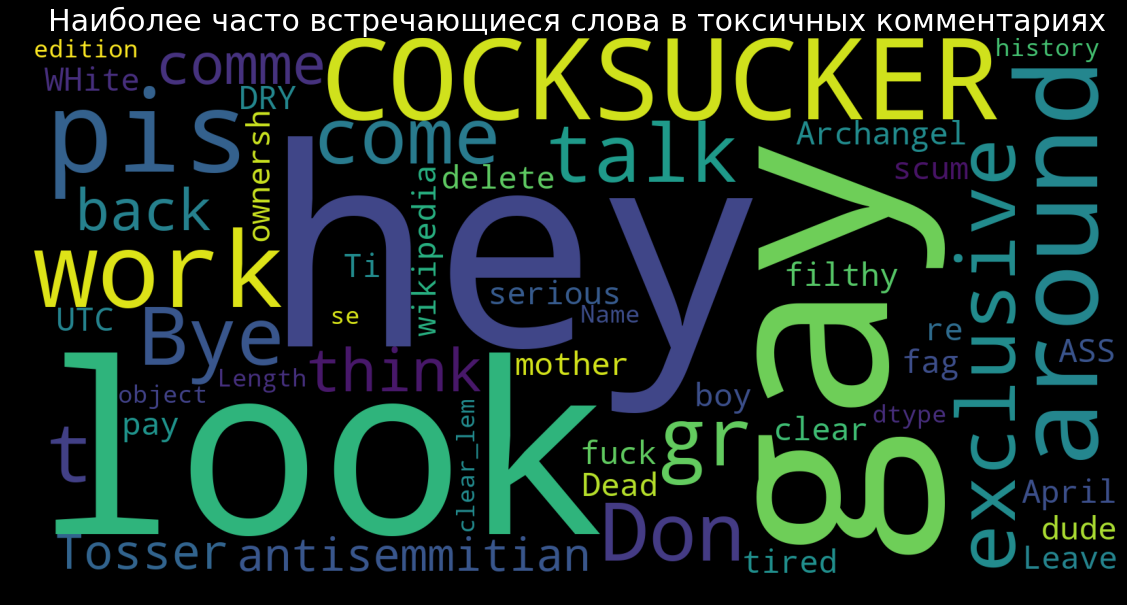

In [14]:
#построим облако слов для токсичных твитов
# готовим размер картинки
wordcloud = WordCloud(width=1600, height=800).generate(str(data_sample.query('toxic==1')['clear_lem']))
plt.figure( figsize=(20,10), facecolor='k');
# добавляем туда облако слов
plt.imshow(wordcloud);
# добавим подписи
plt.title('Наиболее часто встречающиеся слова в токсичных комментариях', fontsize=30, color='white')
plt.show()

Видим наиболее частые слова в негативных комментах (это преимущественно ругательные слова, имеющие отношения к сексуальной ориентации, возможно носящие расистский окрас, религиозный). Помимо нарицательных существительных, глаговов и прилагательных, в перечне присутствуют имена собственные (Tosser): возможно они попали ошибочно и от имен лучше текст очистить, но также возможно это имена неблагожелательных людей и их имена действительно придают негативный окрас комментариям

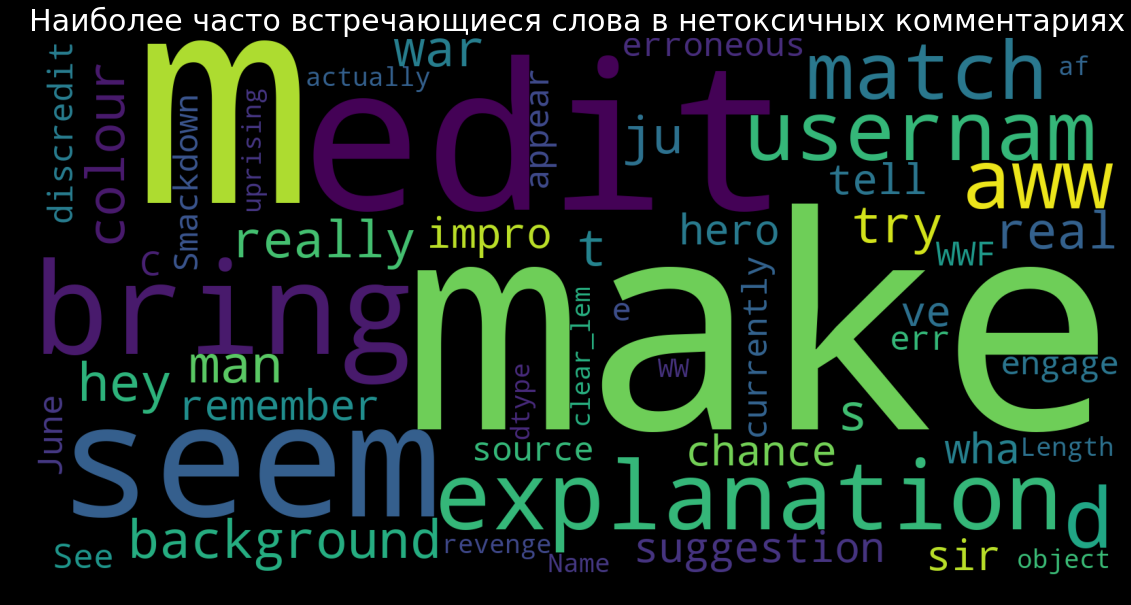

In [15]:
#построим облако слов для нетоксичных твитов
# готовим размер картинки
wordcloud = WordCloud(width=1600, height=800).generate(str(data_sample.query('toxic==0')['clear_lem']))
plt.figure( figsize=(20,10), facecolor='k');
# добавляем туда облако слов
plt.imshow(wordcloud);
# добавим подписи
plt.title('Наиболее часто встречающиеся слова в нетоксичных комментариях', fontsize=30, color='white')
plt.show()

Аналогично негативным, можем увидеть наиболее часто встречающиеся слова в нетоксичных комментариях.


Подготовим данные к обучению
 - объявим целевой признак и прочие, разделим выборку на тренинговую и тестовую.

In [16]:
y = data_sample['toxic']
X = data_sample['clear_lem']

RANDOM_STATE=42
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.25, 
    stratify=y, 
    random_state=42
)

**Вывод по этапу подготовки:**

 - Данные представлены 2-мя столбцами, кол-во строк - 159292, пропуски отсутствуют,дубликаты отсутствуют,
 - Целевой признак не сбалансирован по классами с перевесом в пользу класса 0 в 7 раз. Учтем этот факт при делении датафрейма на обчающую и тестовую выборки,
 - Для ускорения обучения моделей из данных взята выборка в 50000 строк, в которых текс был очищен и лемматизирован,
 - Также проведен частотный анализ текста в виде "облака слов", чтобы получить общее представление о тематике и о наиболее часто встречаемых словах в токсичных и нетоксичных твитах (отражено на вышеуказанной выборке)  
 - Эти данные подготовлены для обучения

## Обучение

Напишем функцию по подбору параметров модели, при которой метрика F1 будет наибольшая, а также по обучению модели с этими параметрами. Учтем, что векторизировать нужно именно тренинговую выборку, чтобы при кросс-валидации не было утечки данных используем пайплайн из векторайзера и модели.
Далее обучим 3 модели.

In [17]:
#напишем функцию по поиску модели с наилучшими параметрами и обучению данной модели
def search_fit(model, parameters):
    pipeline = Pipeline(
        [
        ('tfidf', TfidfVectorizer()),
        ('model', model)
    ])
    search = RandomizedSearchCV(
        estimator=pipeline, 
        param_distributions = parameters, 
        cv = 5,
        n_jobs = -1,
        random_state=RANDOM_STATE,
        scoring = 'f1',
        error_score='raise',
        verbose = 1)
    search.fit(X_train, y_train)
    
    #на выходе получим лучшую метрику, параметры модели и саму модель
    print('Лучшая метрика f1:', round(search.best_score_,2))
    print('Лучшие параметры:', search.best_params_)
    return search

In [18]:
#обучим модель лог регрессии
model_lr = search_fit(
    LogisticRegression(),
    {
        'tfidf__ngram_range': ((1, 1), (1, 2)),
        'model__C':[0.1, 1.0, 10.0],
        'model__solver':['liblinear', 'saga'],
        'model__penalty':['l1','l2']
    }
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшая метрика f1: 0.78
Лучшие параметры: {'tfidf__ngram_range': (1, 1), 'model__solver': 'saga', 'model__penalty': 'l1', 'model__C': 10.0}


In [19]:
#обучим модель дерева решений
model_dtc = search_fit(
    DecisionTreeClassifier(), 
    {
        'tfidf__ngram_range': ((1, 1), (1, 2)),
        'tfidf__min_df': range(1,10),
        'model__criterion':['gini','entropy'],
        'model__max_depth':range(7,15,2)
    }
)

Лучшая метрика f1: 0.61
Лучшие параметры: {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 6, 'model__max_depth': 13, 'model__criterion': 'gini'}


In [20]:
#обучим модель наивного байесовского алгоритма дополнения
model_com = search_fit(
    ComplementNB(), 
    {
        'tfidf__ngram_range': ((1, 1), (1, 2)),
        'tfidf__min_df': range(1,10),
    'tfidf__max_features':range(100, 2000,100),
    'tfidf__norm' : ('l1' , 'l2')
}
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшая метрика f1: 0.62
Лучшие параметры: {'tfidf__norm': 'l1', 'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 6, 'tfidf__max_features': 1900}


Выведем свод по метрикам для всех моделей

In [22]:
#обернем значения метрик в датафрейм
lr = pd.DataFrame(pd.Series(model_lr.best_score_),columns=['best_score_f1'])
dtc = pd.DataFrame(pd.Series(model_dtc.best_score_),columns=['best_score_f1'])
com = pd.DataFrame(pd.Series(model_com.best_score_),columns=['best_score_f1'])
#объединим в одну таблицу, создадим столбец с названиями
models = pd.concat([lr,dtc,com])
models['model'] = ['LogisticRegression','DecisionTreeClassifier','ComplementNB']
#выведем таблицу отсортированную по значению метрики
models.sort_values(by='best_score_f1',ascending=False)

,best_score_f1,model
0,0.78,LogisticRegression
0,0.62,ComplementNB
0,0.61,DecisionTreeClassifier


Наибольшее значение метрика показала на лог регресии. Оценим значение метрики на тесте

In [23]:
round(f1_score(y_test, model_lr.predict(X_test)),2)

0.79

**Вывод по этапу обучения**:
- написана функция по подбору параметров модели, при которой метрика F1 будет наибольшая, а также по обучению модели с этими параметрами.
- с помощью нее обучено 3 модели,
- лучшую метрику при кросс-валидации показала лог регресия, размер метрики F1 на тесте у данной модели составляет более 0.75.

## Выводы

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Данные представлены 2-мя столбцами: с текстом комментария и определением, является ли данные комментарий токсичным (это целевой признак, он не сбалансирован по классами с перевесом в пользу класса 0 в 7 раз).

Была поставлена следующая задача:
 - обучить модель классифицировать комментарии на позитивные и негативные.
 - построить модель со значением метрики качества F1 не меньше 0.75.

Для решение задачи данные были подготовлены следующим образом:
 - Для ускорения обучения моделей из данных взята выборка в 50000 строк, в которых текс был очищен и лемматизирован,
 - Эти данные подготовлены для обучения.
 
Далее было обучено 3 модели, из которых наилучший результат показала лог регрессия, показав значение метрики F1 при кросс-валидации 0.77. Данная модель на тестовых данных показала метрику F1 свыше 0.75. 